# Yorkshire Water -vedenkulutuksen aikasarja-analyysi

Huom! pmdarima ei näytä olevan oletuksena Anacondassa.

In [3]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima

Ladataan alkuperäinen data käsittelyyn.

In [5]:
db_filepath = Path.cwd().parent / "data" / "Daily m3 1315.csv"

# d_df = pd.read_csv("Data/Daily_m3_1315.csv")
d_df = pd.read_csv(db_filepath)

# 24/03/2012 is Saturday
#d_df.index
# print(d_df.columns[:8])
print(f"Number of columns: {len(d_df.columns)}")
print(f"Number of rows: {len(d_df)}")

# d_df.iloc[1279:1304, :10]

Number of columns: 1128
Number of rows: 2596


Etsitään datasta kunnollinen osajoukko, jossa ei ole puuttuvia arvoja.

In [6]:
def etsi_kunnon_df(num_of_properties):
    alku = 3
    loppu = len(d_df.columns) - 1

    kunnon_df = None
    while alku < loppu:
        for a in range(alku, (loppu- alku) // 2, 2):
            sarakkeet = [0, 1, 2] + list(range(a, loppu - a + 1))
            testi_df = d_df.iloc[:, sarakkeet].dropna()
            if len(testi_df) >= num_of_properties:
                return testi_df
        alku += 5
        loppu -= 5
    return kunnon_df

# etsi_kunnon_df(267)
kunnon_df = etsi_kunnon_df(270)

Tarkastetaan negatiiviset arvot, ja asetetaan ne nollaksi.

In [7]:
arvot = kunnon_df.iloc[:, 3:].to_numpy()

print(arvot[arvot < 0])
print(np.where(arvot < 0))
print(kunnon_df.index[354])
print(kunnon_df.iloc[354, 473])
# asetetaan nollaksi
kunnon_df.iloc[354, 473] = 0

[-0.001]
(array([354], dtype=int64), array([470], dtype=int64))
1526
-0.001


#### Autokorrelaatioita

Viiveen kasvaessa korrelaatiot muuttuvat varsin positiivisista lähelle nollaa.

In [8]:
def printtaa_autokorrelaatiot(lag):
    autokorrelaatiot = np.array([kunnon_df.iloc[i, 3:].astype(float).autocorr(lag) for i in range(len(kunnon_df.index))])

    plt.scatter(x=kunnon_df["property"], y=autokorrelaatiot, s=3)
    plt.title(f"Kiinteistöjen autokorrelaatiot ({lag=})")
    plt.xlabel("kiinteistönumero")
    plt.ylabel("autokorrelaatio")
    plt.show()

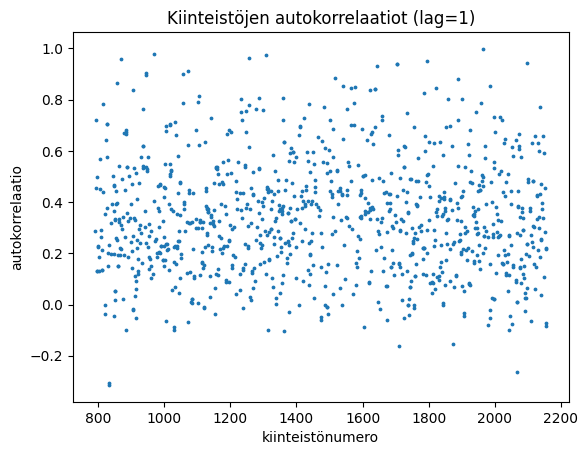

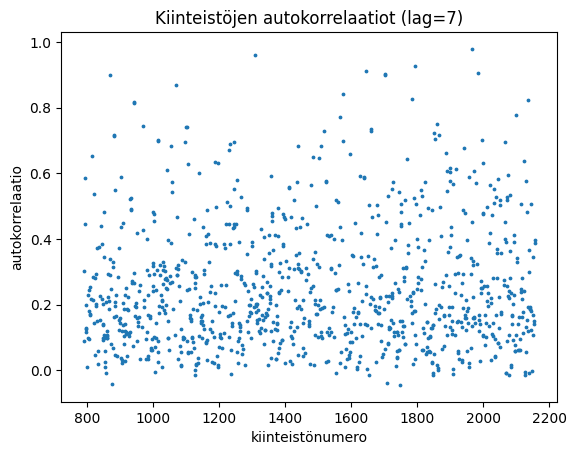

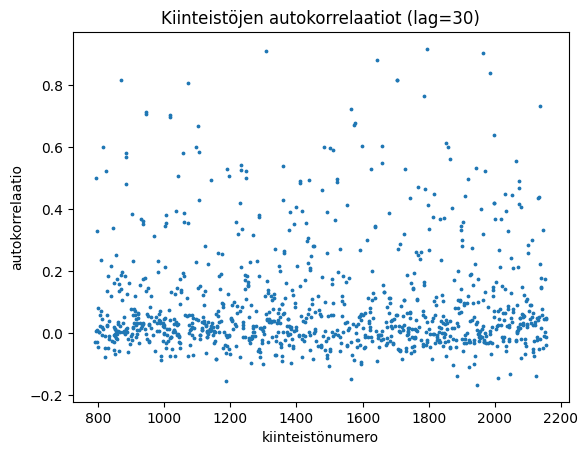

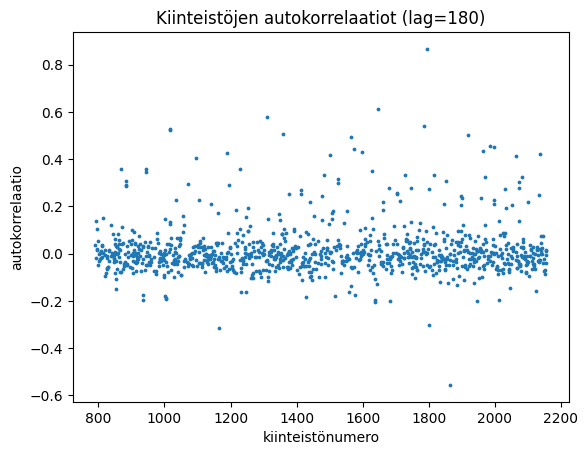

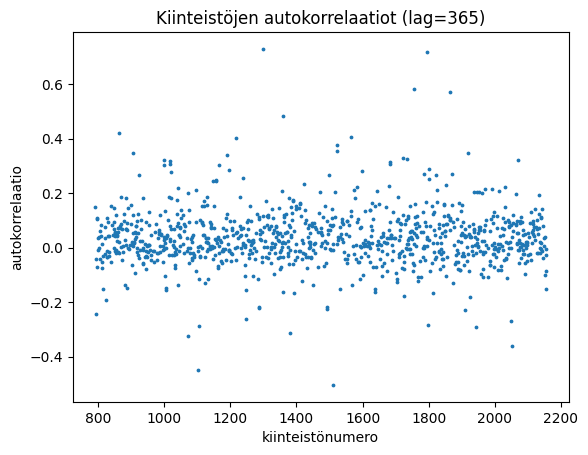

In [9]:
lagit = [1, 7, 30, 180, 365]

for l in lagit:
    printtaa_autokorrelaatiot(l)

#### Muokataan kunnon_df-dataframea aikasarja-analyysia varten

In [10]:
paivat = kunnon_df.columns[3:]
paivat = pd.to_datetime(paivat, dayfirst=True)

def uusi_kiinteisto_nro(rivi):
    if rivi["meter location"] == "external":
        return str(rivi["property"])
    return f'{str(rivi["property"])}.1'

uudet_kiinteisto_nrot = kunnon_df.apply(uusi_kiinteisto_nro, axis=1)

good = kunnon_df.iloc[:, 3:].T
good.columns = uudet_kiinteisto_nrot
good.index = paivat

# kokonaiskulutus omaksi sarakkeeksi
good["Kaikki"] = good.sum(axis=1)

good.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1118 entries, 2012-03-26 to 2015-04-17
Columns: 1017 entries, 791 to Kaikki
dtypes: float64(1017)
memory usage: 8.7 MB


### Varsinainen aikasarja-analyysi

Onko aikasarja stationaarinen? Siltä näyttää.

In [11]:
adft = adfuller(good.iloc[:, -1], autolag="AIC")
output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

        Values                       Metric
0    -4.036497              Test Statistics
1     0.001231                      p-value
2    21.000000             No. of lags used
3  1096.000000  Number of observations used
4    -3.436331          critical value (1%)
5    -2.864181          critical value (5%)
6    -2.568176         critical value (10%)


Yritetään havaita kausivaihtelua.

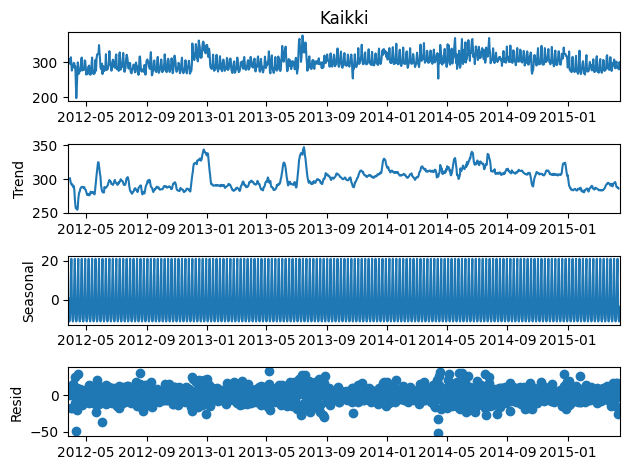

In [12]:
decompose = seasonal_decompose(good.iloc[:, -1], model="additive", period=7)
decompose.plot()
plt.show()

Sovitetaan ARIMA-malli ja piirretään sen perusteella kuvaaja.

In [13]:
def printtaa_aikasarjaennuste(indeksi=None, y_m_d="2015-01-01"):
    if indeksi is None:
        indeksi = np.random.randint(0, len(good.columns))
        print(f"satunnainen sarakeindeksi: {indeksi}")
        print(f"Vastaa kiinteistöä {good.columns[indeksi]}")
    elif indeksi >= 0:
        print(f"sarakeindeksi: {indeksi}")
        print(f"Vastaa kiinteistöä {good.columns[indeksi]}")
    kiinteiston_kulutus = good.iloc[:, indeksi]

    train = kiinteiston_kulutus[:y_m_d]
    test = kiinteiston_kulutus[y_m_d:]

    model = auto_arima(train, error_action="ignore", suppress_warnings=True)
    model.fit(train)
    forecast = model.predict(n_periods=len(test))
    forecast = pd.DataFrame(forecast, index = test.index, columns=["Prediction"])

    pvm = list(good.index).index(pd.to_datetime(y_m_d))
    plt.plot(good.index[:pvm+1], train, label="Koulutusdata")
    plt.plot(good.index[pvm:], test, label="Testidata")
    plt.plot(forecast, label="Ennuste", c="green")
    if indeksi == -1:
        otsikko = "Vedenkulutus kokonaisuudessaan"
    else:
        otsikko = f"Vedenkulutus kiinteistössä {good.columns[indeksi]}"
    plt.title(otsikko)
    plt.xlabel("Kuukausi")
    plt.xticks(rotation=45)
    plt.ylabel("Kulutus (m3)")
    # onko satunnaiset viivat ok?
    # plt.axhline(y=train.mean(), color="grey", linestyle="--")
    plt.axhline(y=train[-1], color="grey", linestyle="--")
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

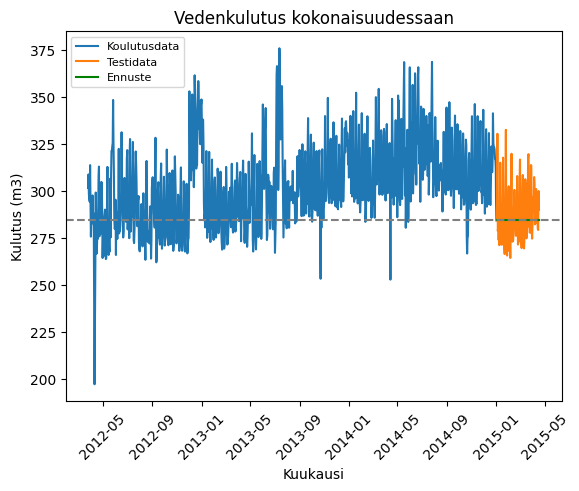

In [14]:
printtaa_aikasarjaennuste(-1)